In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

14:42:39 [I] klustakwik KlustaKwik2 version 0.2.6


In [5]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [6]:
# output = pathlib.Path('output/stimulus-lfp-response')
# (output / 'figures').mkdir(parents=True, exist_ok=True)

In [7]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [8]:
a = sessions.iloc[0]

In [9]:
a.to_dict()

{'action': '1849-060319-3',
 'baseline': True,
 'entity': 1849,
 'frequency': nan,
 'i': False,
 'ii': True,
 'session': 3,
 'stim_location': nan,
 'stimulated': False,
 'tag': 'baseline ii'}

In [10]:
channel_groups = []
for i, row in sessions.iterrows():
    for ch in range(8):
        row['channel_group'] = ch
        channel_groups.append(row.to_dict())

In [11]:
channel_groups = pd.DataFrame(channel_groups)

In [12]:
def get_lim(action_id):
    stim_times = data_loader.stim_times(action_id)
    stim_times = np.array(stim_times)
    return [stim_times.min(), stim_times.max()]

def get_mask(lfp, lim):
    return (lfp.times >= lim[0]) & (lfp.times <= lim[1])

def zscore(a):
    return (a - a.mean()) / a.std()

def stim_freq(action_id):
    stim_times = np.array(data_loader.stim_times(action_id))
    return 1 / np.mean(np.diff(stim_times))

In [13]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def select_and_clean(anas, width=500, threshold=2):
    anas = np.array(anas)

    for ch in range(anas.shape[1]):
        idxs, = np.where(abs(anas[:, ch]) > threshold)
        for idx in idxs:
            anas[idx-width:idx+width, ch] = 0 # TODO AR model prediction
    return anas

In [14]:
def energy(p, f, f_c, f_w):
    mask = (f > f_c - f_w) & (f < f_c + f_w)
    df = f[1] - f[0]
    return np.sum(p[mask]) * df

In [106]:
def theta_peak(p, f):
    mask = (f > 6) & (f < 10)
    p_m = p[mask]
    f_m = f[mask]
    peaks, _ = find_peaks(p_m)
    idx = np.argmax(p_m[peaks])
    return f_m[peaks[idx]], p_m[peaks[idx]]

In [107]:
def half_width(p, f, m_p, m_f):
    m_p_half = m_p / 2
    half_p = p - m_p_half
    idx_f = np.where(f <= m_f)[0].max()
    idxs_p1, = np.where(np.diff(half_p[:idx_f + 1] > 0) == 1)
    m1 = idxs_p1.max()
    idxs_p2, = np.where(np.diff(half_p[idx_f:] > 0) == 1)
    m2 = idxs_p2.min() + idx_f    
#     plt.plot(f, p)
#     plt.plot(m_f, m_p, marker='o', ls='none', markersize=10)
#     plt.plot(f[m1], p[m1], marker='x', ls='none', markersize=10, c='r')
#     plt.plot(f[m1+1], p[m1+1], marker='+', ls='none', markersize=10, c='r')
    
#     plt.plot(f[m2], p[m2], marker='x', ls='none', markersize=10, c='k')
#     plt.plot(f[m2+1], p[m2+1], marker='+', ls='none', markersize=10, c='k')
    
#     plt.xlim(4,12)
    assert p[m1] < m_p_half < p[m1+1], (p[m1], m_p_half, p[m1+1])
    assert p[m2] > m_p_half > p[m2+1], (p[m2], m_p_half, p[m2+1])
    
    f1 = interp1d([half_p[m1], half_p[m1 + 1]], [f[m1], f[m1 + 1]])(0)
    f2 = interp1d([half_p[m2], half_p[m2 + 1]], [f[m2], f[m2 + 1]])(0)
    return f1, f2

In [108]:
def stim_peak(p, f, s_f):
    return interp1d(f, p)(s_f)

In [109]:
def process(row):
    action_id = row['action']
    channel_group = row['channel_group']
    lfp = data_loader.lfp(action_id, channel_group)
    
    

In [110]:
action_id_0 = '1839-060619-1'
action_id_1 = '1833-260619-2'

In [128]:
lfp_0 = data_loader.lfp(action_id_0, 3)
lfp_1 = data_loader.lfp(action_id_1, 2)

In [129]:
lfp3_ = data_loader.lfp(action_id_1, 3)
lfp6_ = data_loader.lfp(action_id_1, 6)
lfp3 = select_and_clean(lfp3_)
lfp6 = select_and_clean(lfp6_)
s3 = signaltonoise(lfp3)
s6 = signaltonoise(lfp6)

print(s3)
print(s6)

[ 0.00116826 -0.00226905  0.00884092  0.00689327]
[0.00286196 0.00965367 0.00540679 0.00102636]


In [130]:
lfp3.shape

(856781, 4)

(6, 12)

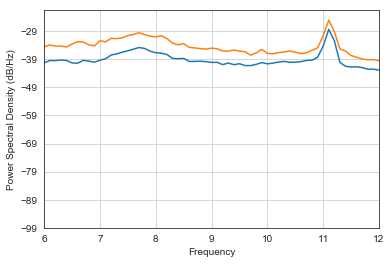

In [131]:
plt.psd(lfp3[:, 2].ravel(), Fs=lfp3_.sampling_rate.magnitude, NFFT=10000)
plt.psd(lfp6[:, 1].ravel(), Fs=lfp6_.sampling_rate.magnitude, NFFT=10000)
plt.xlim(6,12)

In [132]:
clean_lfp_0 = select_and_clean(lfp_0)
clean_lfp_1 = select_and_clean(lfp_1)

In [133]:
best_channel_0 = np.argmax(signaltonoise(clean_lfp_0))
best_channel_1 = np.argmax(signaltonoise(clean_lfp_1))

In [134]:
lim_1 = get_lim(action_id_1)

(59.32180000000001, 659.2845666666667)

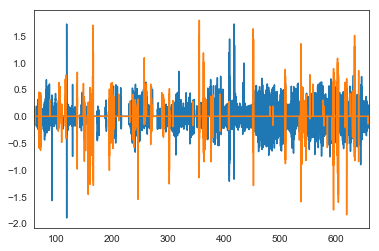

In [135]:
plt.plot(lfp_0.times, clean_lfp_0[:,best_channel_0])
plt.plot(lfp_1.times, clean_lfp_1[:,best_channel_1])
plt.xlim(lim_1)

In [136]:
any(mask_1)

True

(0, 20)

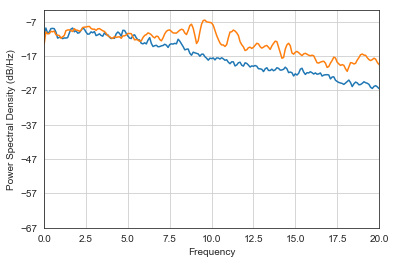

In [137]:
signal_0 = zscore(clean_lfp_0[:, best_channel_0].ravel())
p_xx_0, freq_0 = plt.psd(signal_0, Fs=lfp_0.sampling_rate.magnitude, NFFT=10000)

mask_1 = get_mask(lfp_1, lim_1)
signal_1 = zscore(clean_lfp_1[mask_1, best_channel_1].ravel())
p_xx_1, freq_1 = plt.psd(signal_1, Fs=lfp_1.sampling_rate.magnitude, NFFT=10000)
plt.xlim(0,20)

In [138]:
f_max_0, p_max_0 = theta_peak(p_xx_0, freq_0)

In [139]:
theta_peak(p_xx_1, freq_1)

(9.600000000000001, 0.2214935569189184)

In [140]:
energy(p_xx_0, freq_0, f_max_0, .5)

0.04301376000519899

In [141]:
energy(p_xx_1, freq_1, f_max_0, 1)

0.13457752994772074

In [142]:
stim_freq_1 = stim_freq(action_id_1)

In [143]:
p_max_1 = stim_peak(p_xx_1, freq_1, stim_freq_1)

In [144]:
p_max_0, p_max_1

(0.0685831695307859, array(0.09971924))

In [145]:
energy(p_xx_1, freq_1, stim_freq_1, .5)

0.07856072798300642

In [146]:
energy(p_xx_1, freq_1, 150, 150), energy(p_xx_0, freq_0, 150, 150)

(1.513483253361768, 0.9170797402905564)

(array(7.16863111), array(8.04187682))

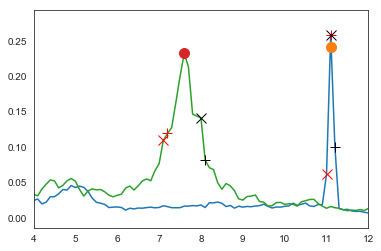

In [291]:
half_width(p_xx_1, freq_1, p_max_1, stim_freq_1)

half_width(p_xx_0, freq_0, p_max_0, f_max_0)

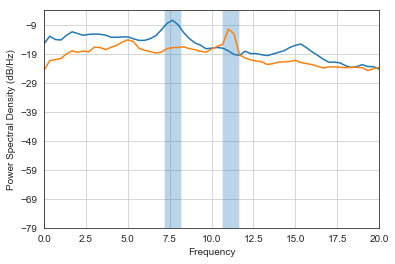

In [111]:

plt.psd(signal_0, Fs=lfp_0.sampling_rate.magnitude, NFFT=3000)

plt.psd(signal_1, Fs=lfp_1.sampling_rate.magnitude, NFFT=3000)
plt.xlim(0,20)
window = .5
plt.axvspan(f_max_0 - window, f_max_0 + window, alpha=.3)
plt.axvspan(stim_freq_1 - window, stim_freq_1 + window, alpha=.3)

# Save to expipe

In [10]:
action = project.require_action("stimulus-lfp-response")

In [11]:
# action.modules['parameters'] = {
#     'window_size': window_size,
#     'std_gaussian_kde': std_gaussian_kde
# }

In [12]:
action.data['results'] = 'results.csv'
results.to_csv(action.data_path('results'), index=False)

In [13]:
copy_tree(output, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/summary_histogram.png']

In [14]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-lfp-response.ipynb")